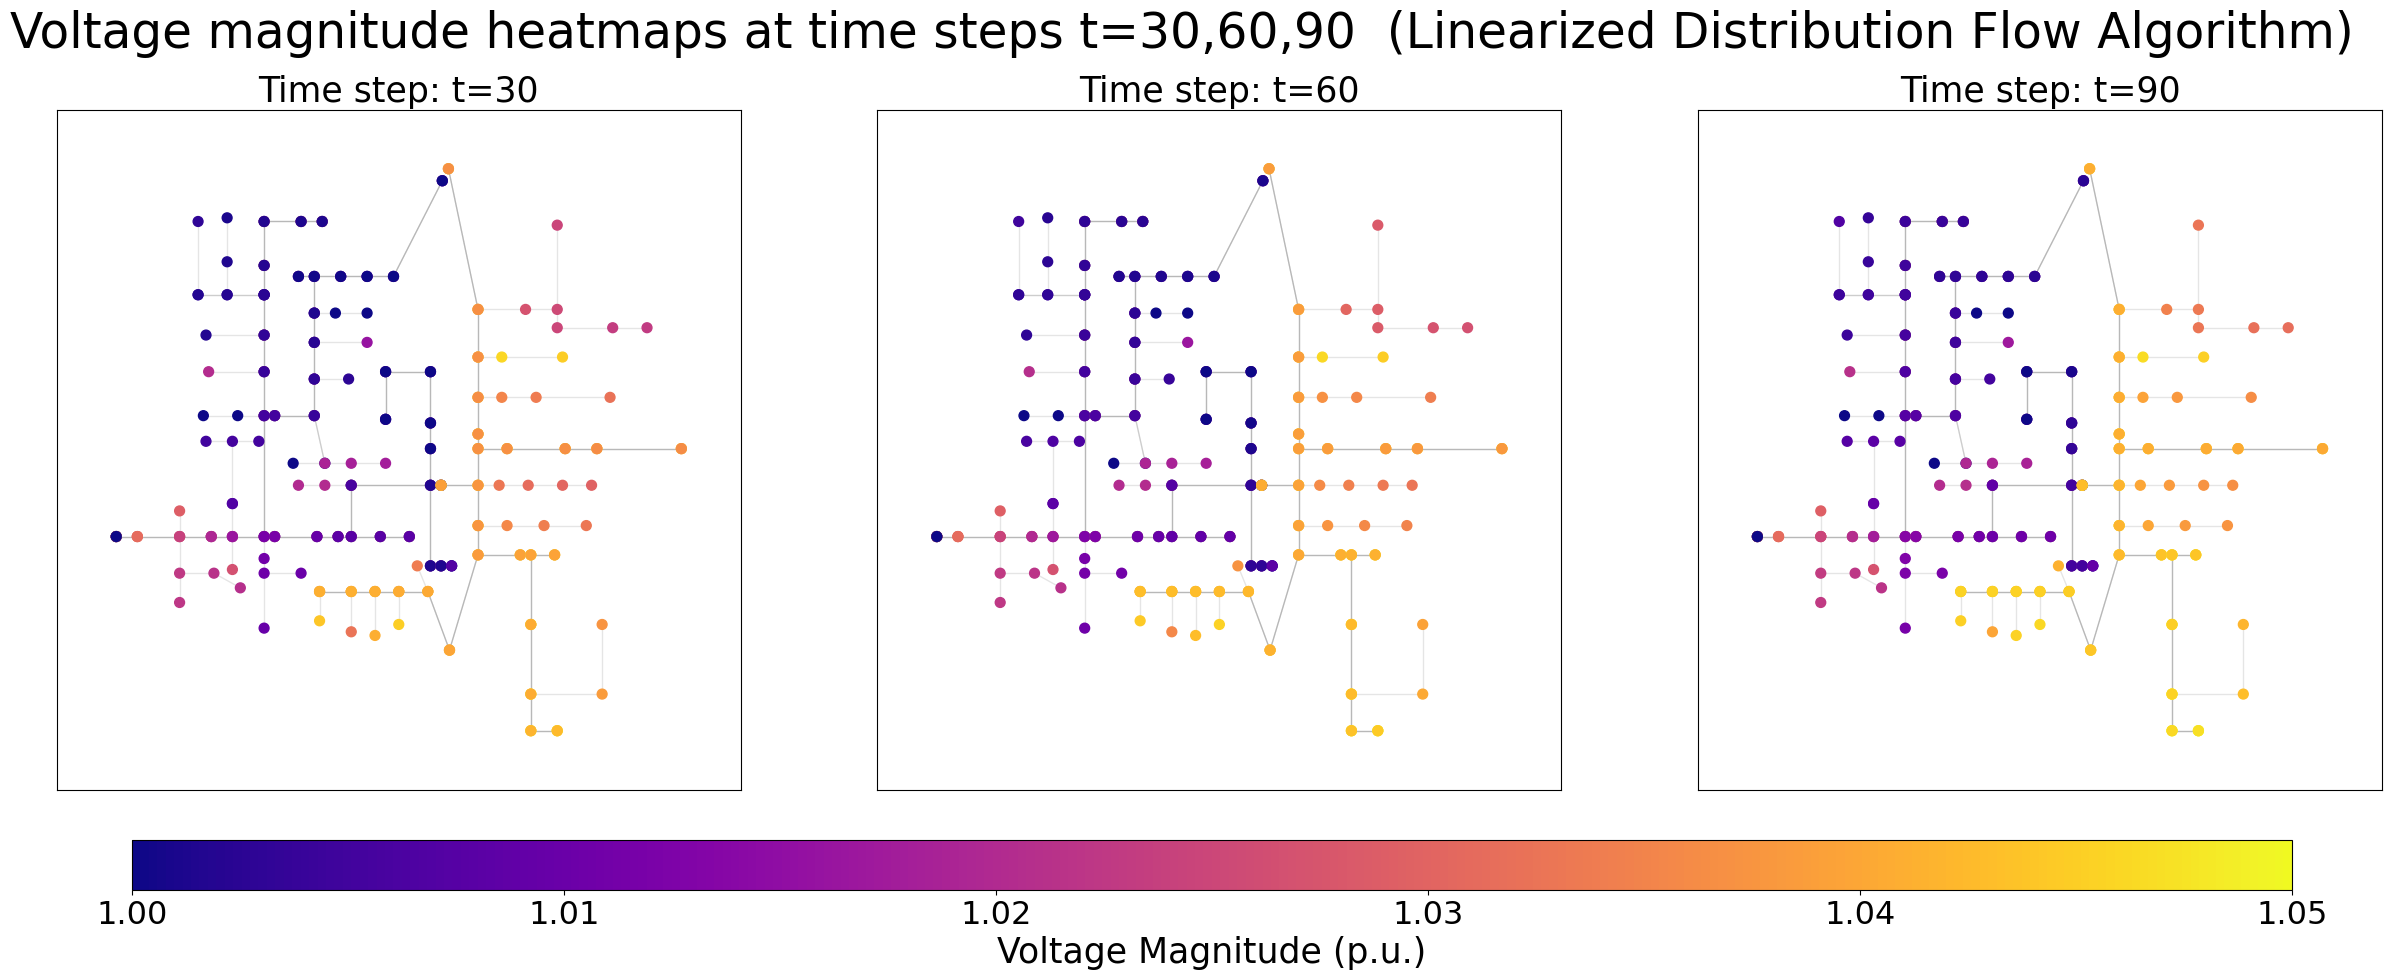

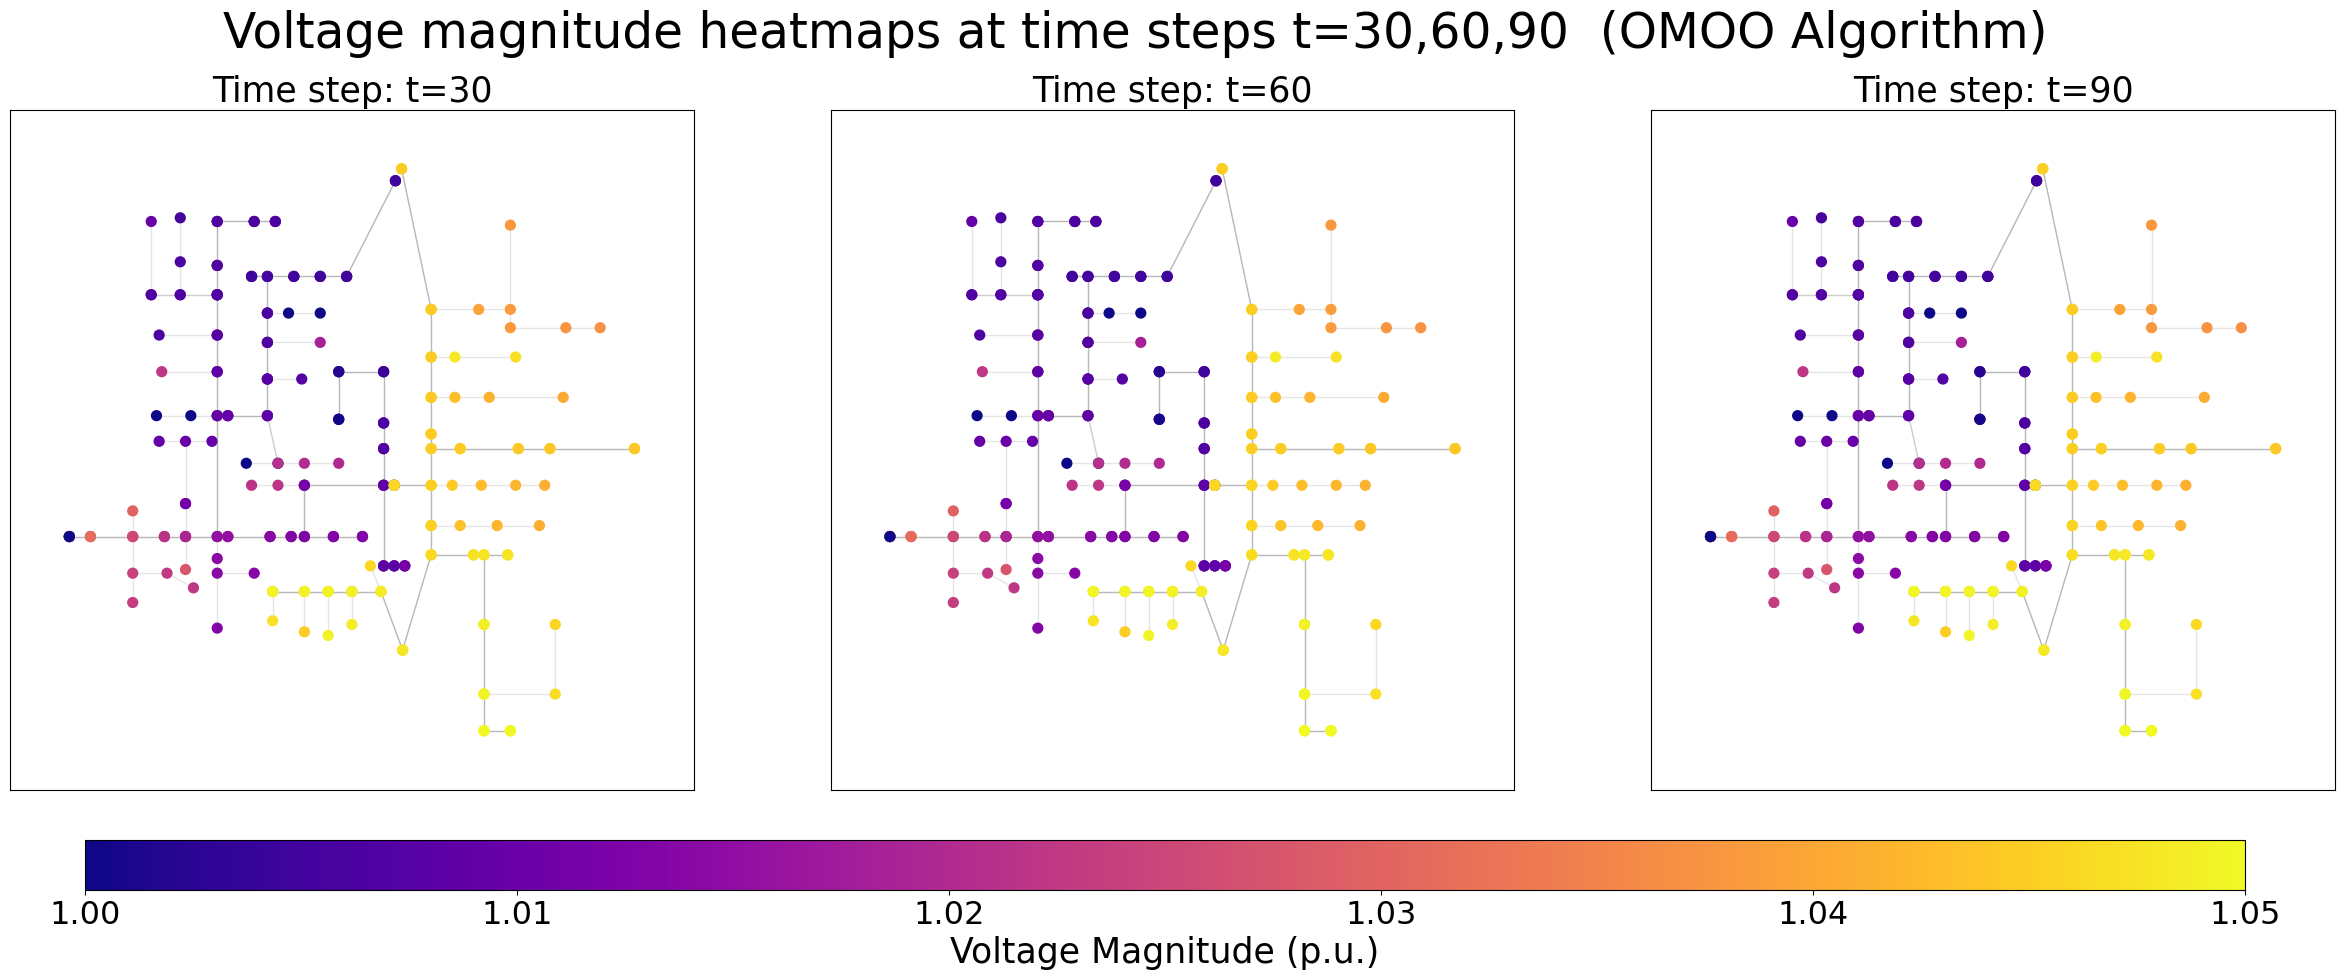

In [3]:
import os
import plotter

case = "ieee123"
directory1 = f"../outputs/{case}"
topology_filepath = os.path.join(directory1, "topology.json")
buscoord_filepath = os.path.join(directory1, "BusCoords.dat")
real_voltage_filepath = os.path.join(directory1, "voltage_real.feather")
imag_voltage_filepath = os.path.join(directory1, "voltage_imag.feather")


time = [30,60,90]
fig_filename = os.path.join(directory1, f"network_{case}.png")
plotter.plot_network(
    topology_filepath,
    buscoord_filepath, 
    real_voltage_filepath, 
    imag_voltage_filepath, 
    root_node='150R', sep="    ",
    time=time, node_size=50, 
    show=True, to_file=fig_filename, 
    suptitle_sfx = "(Linearized Distribution Flow Algorithm)"
    )


case = "omoo"
directory2 = f"../outputs/{case}"
topology_filepath = os.path.join(directory1, "topology.json")
buscoord_filepath = os.path.join(directory2, "BusCoords.dat")
real_voltage_filepath = os.path.join(directory2, "voltage_real.feather")
imag_voltage_filepath = os.path.join(directory2, "voltage_imag.feather")


time = [30,60,90]
fig_filename = os.path.join(directory2, f"network_{case}.png")
plotter.plot_network(
    topology_filepath,
    buscoord_filepath, 
    real_voltage_filepath, 
    imag_voltage_filepath, 
    root_node='150R', sep="    ",
    time=time, node_size=50, 
    show=True, to_file=fig_filename,
    suptitle_sfx = "(OMOO Algorithm)"
    )


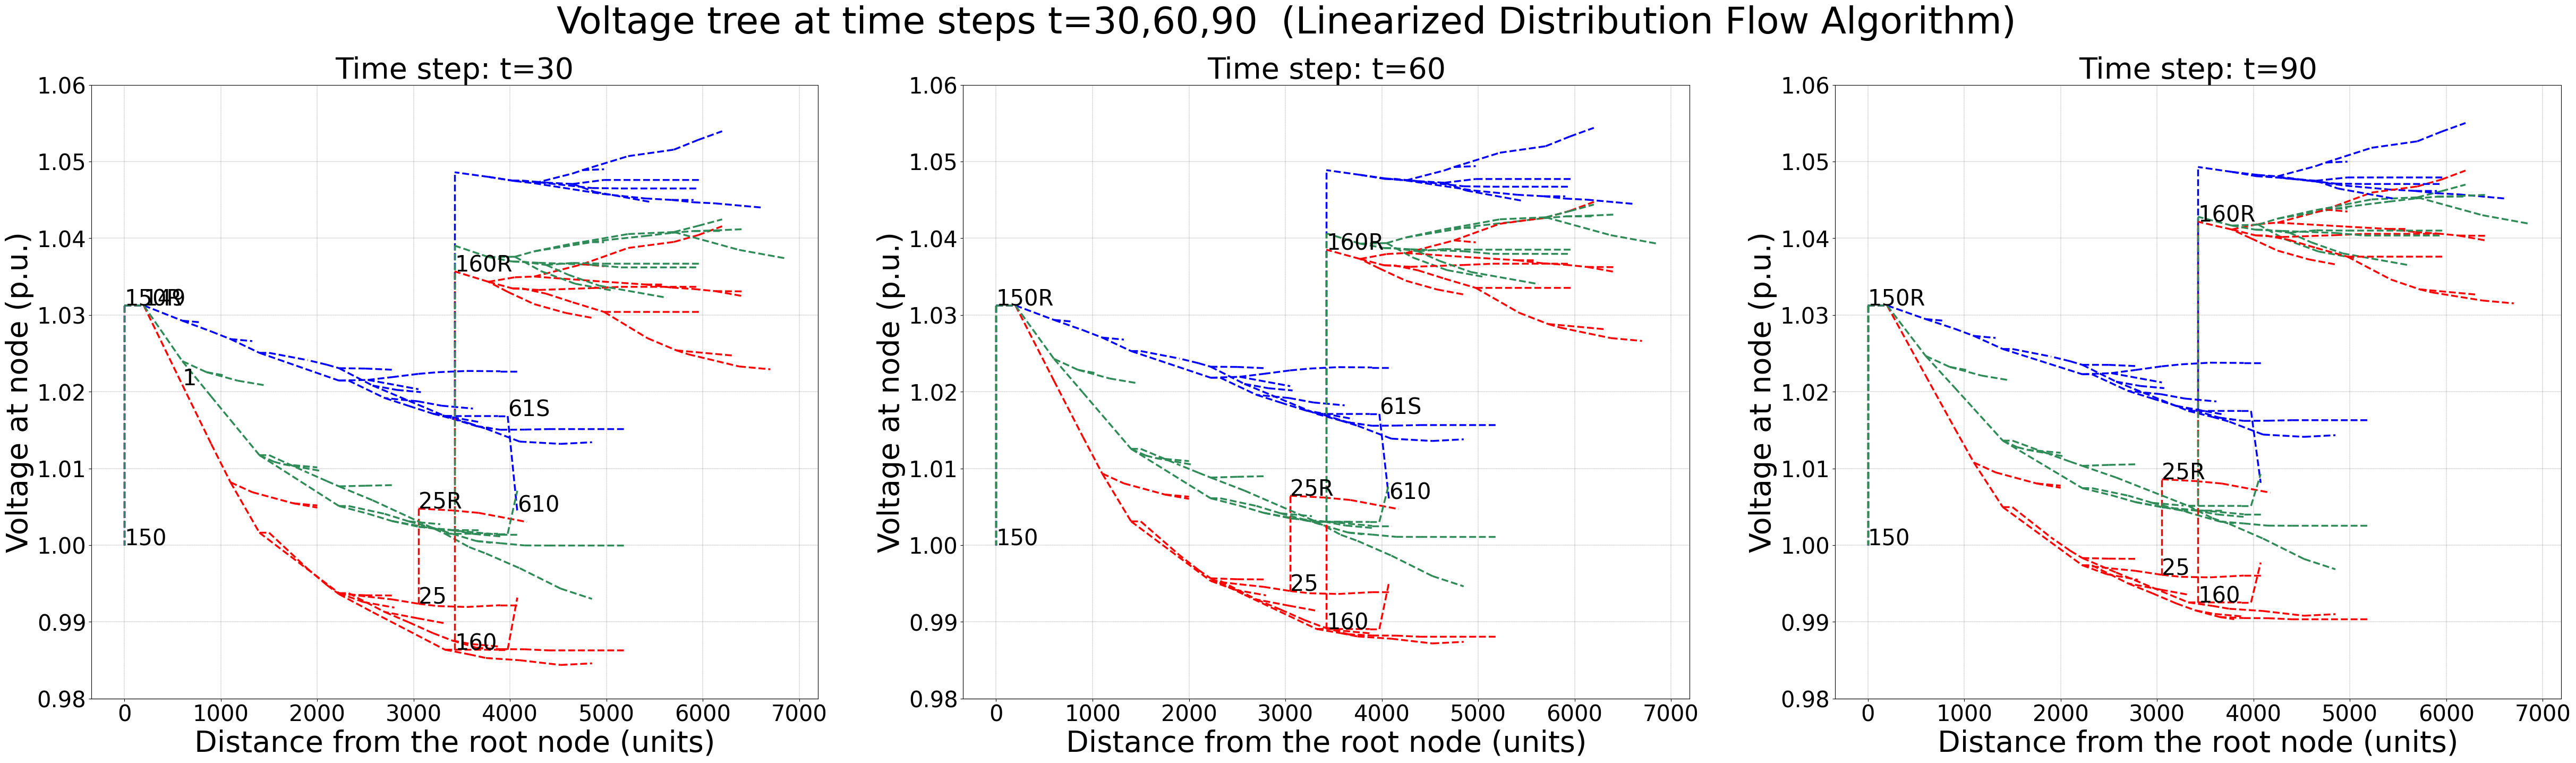

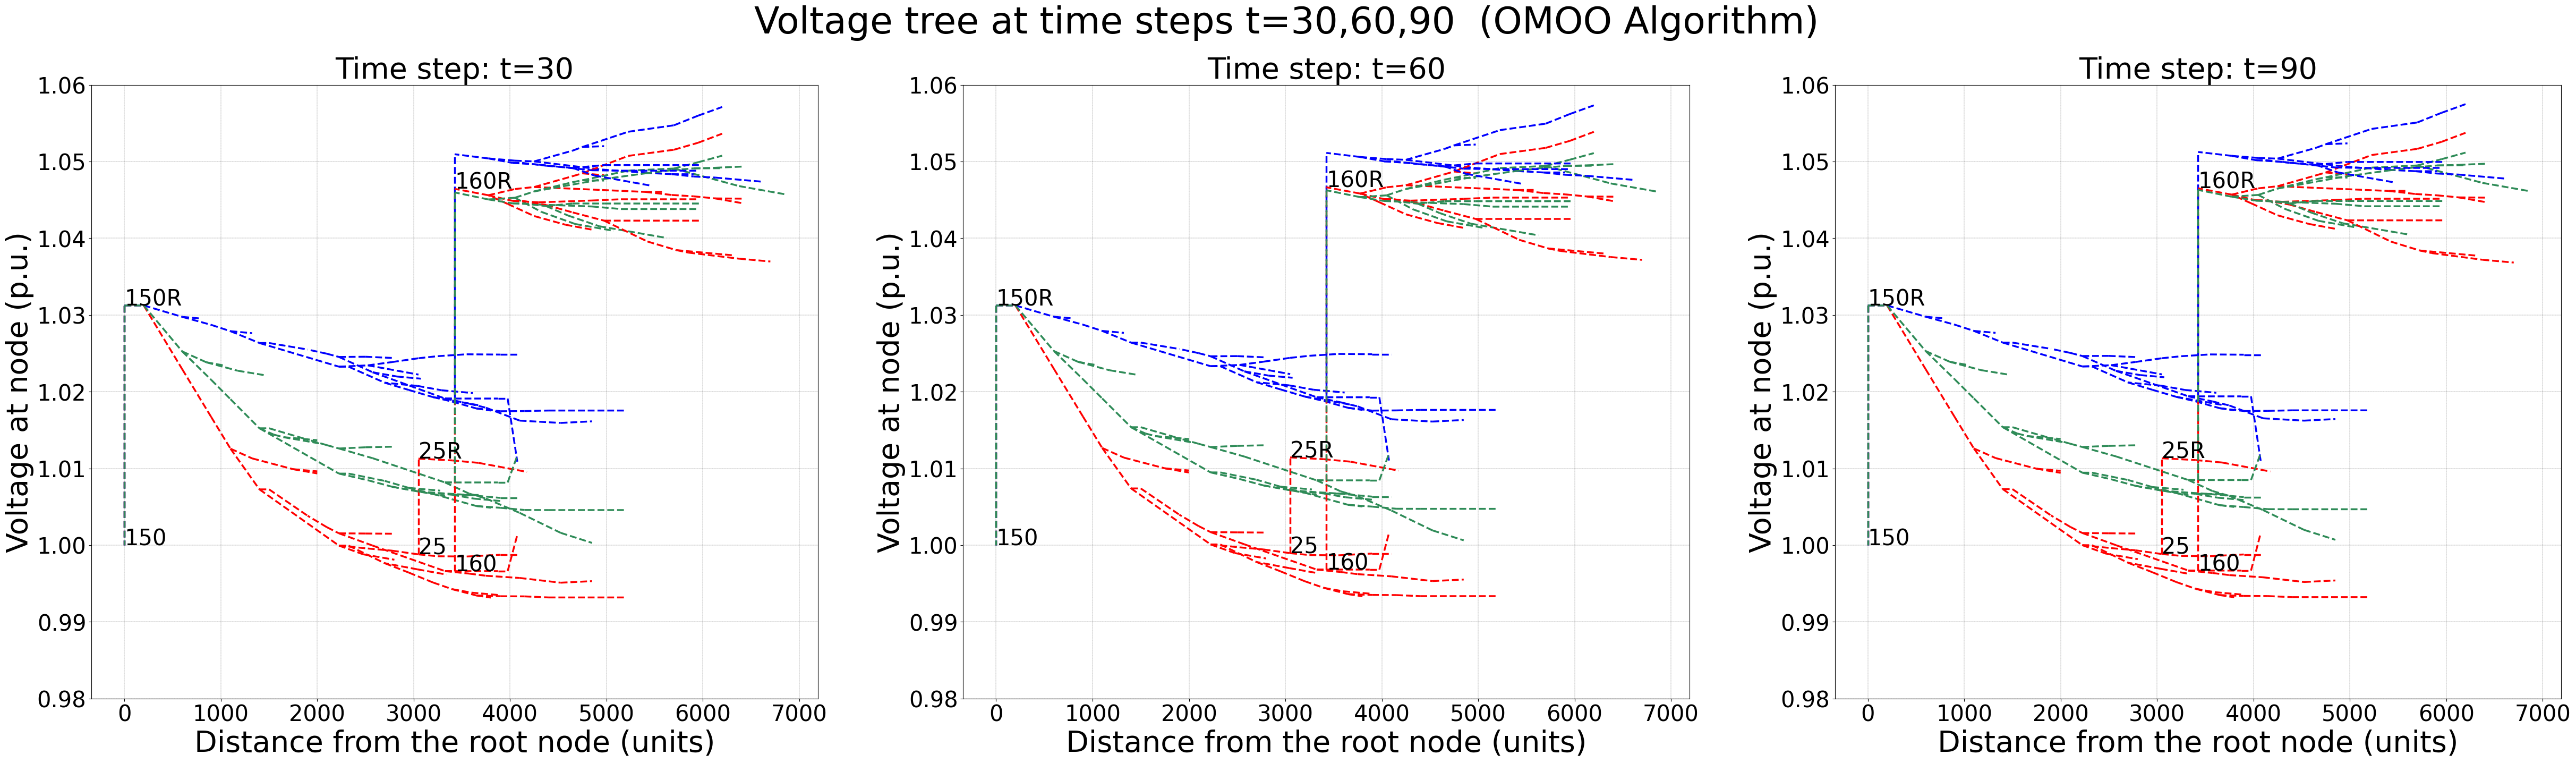

In [1]:
import os
import plotter

case = "ieee123"
directory1 = f"../outputs/{case}"
topology_filepath = os.path.join(directory1, "topology.json")
buscoord_filepath = os.path.join(directory1, "BusCoords.dat")
real_voltage_filepath = os.path.join(directory1, "voltage_real.feather")
imag_voltage_filepath = os.path.join(directory1, "voltage_imag.feather")


time = [30,60,90]
fig_filename = os.path.join(directory1, f"vtree_{case}.png")
plotter.plot_voltage_tree(
    topology_filepath,
    buscoord_filepath, 
    real_voltage_filepath, 
    imag_voltage_filepath,
    root_node='150R', 
    time=time,
    show=True, to_file=fig_filename,
    lw=2.5, ls='dashed', 
    figsize=(60,15),
    annotate=True,
    suptitle_sfx = "(Linearized Distribution Flow Algorithm)"
    )

case = "omoo"
directory2 = f"../outputs/{case}"
topology_filepath = os.path.join(directory1, "topology.json")
buscoord_filepath = os.path.join(directory2, "BusCoords.dat")
real_voltage_filepath = os.path.join(directory2, "voltage_real.feather")
imag_voltage_filepath = os.path.join(directory2, "voltage_imag.feather")


time = [30,60,90]
fig_filename = os.path.join(directory2, f"vtree_{case}.png")
plotter.plot_voltage_tree(
    topology_filepath,
    buscoord_filepath, 
    real_voltage_filepath, 
    imag_voltage_filepath,
    root_node='150R', sep="    ",
    time=time,
    show=True, to_file=fig_filename,
    lw=2.5, ls='dashed', 
    figsize=(60,15),
    annotate=True,
    suptitle_sfx = "(OMOO Algorithm)",
    )